# Rewrite of POLE with Numpy, written by Conrad
(See e.g. "Including Systematic Uncertainties in Confidence Interval Construction for Poisson Statistics")
- Cole Kampa
- 5-5-2021

# Imports (Python)

In [1]:
import numpy as np

# Completed Functions (Python)

In [2]:
# same as before
def readin(filename='data/pole1.0.ini', verbose=True):
    # read in initialization file. remove newline character and ignore comments (line starts with "!")
    with open(filename, 'r') as f:
        lines = [i.rstrip('\n').rstrip(' ') for i in f.readlines() if not i[0] in ['!', '#', '*', 'C']]#, 'c', ]]
    # loop through lines to set proper variables
    for line in lines:
        #print(line)
        ident, val = line.split(' ')
        if ident=='of':
            filehb = val
        elif ident=='ft':
            filltrue = int(val)
        elif ident=='ff':
            fluxfactor = float(val)
        elif ident=='ll':
            conflevel = float(val)
        elif ident=='fi':
            filetrue = int(val)
        elif ident=='fn':
            filein = val
        elif ident=='fo':
            fileout = val
        elif ident=='rf':
            fmax = float(val)
        elif ident=='sw':
            width = float(val)
        elif ident=='no':
            normtrue = int(val)
        elif ident=='fc':
            FCtrue = int(val)
        elif ident=='bg':
            background = float(val)
        elif ident=='nm':
            nobs = int(val)
        elif ident=='cc':
            ctrue = int(val)
        elif ident=='bu':
            sbg = float(val)
        elif ident=='pb':
            bkpar = int(val)
        elif ident=='eu':
            sac = float(val)
        elif ident=='pu':
            spar = int(val)
        elif ident=='eb':
            bsac = float(val)
        elif ident=='pe':
            bar = int(val)
    # calculate number of steps
    step_help = fmax/width
    steps = int(step_help)
    if verbose:
        # Tell User which parameters: 
        print('Performing Conf Belt Const :')
        print(f'Output hbfile:     {filehb}')  
        print(f'fill diagnostic histos {filltrue}')
        print(f'Confidence Level {conflevel:0.5f}')
        print(f'Condition (1=yes) {normtrue}')
        print(f'stepwidth : {width:0.3f}')
        print(f'Feldman Cousins    {FCtrue}')
        print(f'fluxfactor:        {fluxfactor:0.3f}')
        print(f'Read from file: {filein}')
        print(f'Write to file: {fileout}')
        print(f'Exp. BG events     {background:0.3f}')
        print(f'Measured events    {nobs}')
        print(' ')
        print('Used Paramterisation :')
        print('Gaussian = 1')
        print('flat = 2')
        print('log-normal = 3')
        print(' ')
        print(f'rel Aeff unc (sig): {sac:0.3f}')
        print(f'Parametrization: {spar}')
        print(f'rel Aeff unc (bck): {bsac:0.3f}')
        print(f'Parametrization: {bar}')
        print(f'rel bg unc:        {sbg:0.3f}')
        print(f'Parametrization: {bkpar}')
        print(f'max flux:          {fmax:0.3f}')
        print(f'Number of steps: {steps}')
        print('CAUTION: not bigger than 1000!')
    #return lines
    return filehb, filltrue, fluxfactor, conflevel, filetrue, filein, fileout, fmax, width,\
           normtrue, FCtrue, background, nobs, ctrue, sbg, bkpar, sac, spar, bsac, bar, steps

In [3]:
# same as before
def read_grid(filename='data/test.in'):
    '''
    x = background
    y = number of observed events
    '''
    x = []; y = []
    # read in input file. remove newline character
    with open(filename, 'r') as f:
        lines = [i.rstrip('\n').rstrip(' ') for i in f.readlines()]
    # loop through lines to grab x, y values set proper variables
    for line in lines:
        y_, x_ = line.split(' ')
        x.append(float(x_))
        y.append(float(y_))
    x = np.array(x)
    y = np.array(y)
    ncalc = len(x)
    return x, y, ncalc

In [127]:
#def fluxfactors(sac,bsac,sbg,ctrue):
def fluxfactors(sac,bsac,sbg,ctrue,N_exp):
    sigfactor = np.zeros((3,N_exp)) # signal eff. unc.
    befactor = np.zeros((3,N_exp)) # bg eff. unc.
    bkfactor = np.zeros((3,N_exp)) # expected bg unc.
    # Gaussian distribution; mu=0, std=1
    a,b,r = np.random.normal(loc=0, scale=1, size=(3, N_exp))

    # Uniform distribution 
    #call ranlux(ranvec,3)
    ranvec = np.random.uniform(low=0, high=1, size=(3, N_exp))

    # Conrad
    sigfactor[0] = 1+sac*r
    sigfactor[1] = (1-sac)+2*ranvec[0]*sac
    sigfactor[2] = np.exp(sac*r - sac**2/2)

    # background efficiency factors
    if (ctrue == 1): # correlated
        befactor[0] =  1+bsac*r
        befactor[1] =  (1-bsac)+2*ranvec[0]*bsac
        # mean of logN will be 1
        befactor[2] = np.exp(bsac*r - bsac**2/2)
    else: # no correlation
        befactor[0] =  1+bsac*a
        befactor[1] =  (1-bsac)+2*ranvec[1]*bsac
        # mean of logN will be 1
        befactor[2] = np.exp(bsac*a - bsac**2/2)

    # background prediction factors.
    bkfactor[0] = (1+sbg*b)
    bkfactor[1] = (1-sbg)+2*ranvec[2]*sbg     
    bkfactor[2] = np.exp(sbg*b - sbg*bsac/2)
    
    return sigfactor, befactor, bkfactor

def fluxlim(trisigflu, sac, sbg, k, normtrue, used, fluxfactor,
            background, nobs, bsac, width, filltrue, ctrue, spar, bar, bkpar, conflevel,
            N_exp):
    # PYTHON
    #fntot = [] # container for each experiment n_tot
    # Take flux from our MC
    bckfluxnom = background/fluxfactor
    # Perform Pseudo Experiments to calculate Integrals
    # number of experiments
    #N_exp = 100000
    #N_exp = 1000000
    #for i in range(100000): # change so this isn't hardcoded
    # TESTING WITH FEWER GENERATED EXPERIMENTS
    #for i in range(10000): # change so this isn't hardcoded
    ###sigfactor, befactor, bkfactor = fluxfactors(sac, bsac, sbg, ctrue)
    sigfactor, befactor, bkfactor = fluxfactors(sac, bsac, sbg, ctrue, N_exp)
    # uncertainty in background flux    
    bckflux = bckfluxnom*bkfactor[bkpar-1] # check bkpar indexing
    # Diagnostics histograms
    if (filltrue == 1): 
        #call hfill(k+2000,bkfactor(bkpar),1.,1.)
        # FIXME!
        pass
    # include flux uncertainty
    musignal = trisigflu*fluxfactor*sigfactor[spar-1] # check indexing
    mubck  = bckflux*befactor[bar-1] # check indexing
    # Truncation for Gaussian uncertainty
    mask_trunc = (musignal < 0.) | (mubck < 0.)
    musignal[mask_trunc] = 0.
    mubck[mask_trunc] = 0.
    ## FIX ME!!
    #mask = (musignal < 0.) | (mubck < 0.)
    #if (musignal < 0.) or (mubck < 0.):
    #    continue # want next iteration
    # generate signal and background
    nsig = np.random.poisson(lam=musignal, size=N_exp)
    nbck = np.random.poisson(lam=mubck, size=N_exp)
    #if (normtrue==0): # without normalization
    n_tot = nsig+nbck # total number observed
    # fntot.append(float(n_tot))
    fntot = n_tot.astype(np.float)
    # Diagnostics
    if (filltrue==1):
        # call hfill(k+100,fntot(nc),1.,1.)
        pass
#     else: # with normalization
#         # only keep event if nobs > nbck
#         # should verify this enforces behavior given by cond
#         if (nbck < nobs):  # < or <= ?
#             n_tot = nsig+nbck
#             fntot.append(float(n_tot))
#             if (filltrue==1):
#                 #call hfill(k+100,fntot(i),1.,1.)
#                 pass
#         else:
#             continue

    #fntot = np.array(fntot) # convert to array
    # truncate
    #mask_trunc = (musignal < 0.) | (mubck < 0.)
    fntot = fntot[~mask_trunc]
    # normalization
    if normtrue != 0:
        mask_norm = (nbck < nobs)
        fntot = fntot[~mask_norm]
    # normalizations, FC
    # sort in ascending order
    fntot = np.sort(fntot)
    # limiting index for Neyman UL
    jlim = round((1.-conflevel)*len(fntot)) - 1 # integer. if you use int() it rounds down!
    intjlim = jlim # unnecessary--using round
    nlim= fntot[intjlim]

    # make histogram "N Hist" (new for python version)
    dist, _ = np.histogram(fntot, bins=np.arange(0,101,1)) # maybe 0, 102 so 100 is in different bin than 99
    #dist, _ = np.histogram(fntot, bins=np.arange(0,102,1)) # maybe 0, 102 so 100 is in different bin than 99
    noent = np.sum(dist) # number of entries in histogram

    # FIXME
    # needed for FC?
    #####call hfill(40,nlim,trisigflu,1.)

    # default value for checking later
    resflux = -1000 # can never be encountered for counting experiment
    # calculate Neyman upper limit for the passed in n0
    if (nlim == nobs+1):
        if (used == 0):
            resflux = trisigflu-width
            print(f'\nNeyman Upper Limit: {resflux}')
            #print *,' '
            #print 300,'Neyman Upper limit:',resflux
        used = 1

    return dist, noent, used, resflux, nlim
    # can derive noent from dist, but leaving for now

In [128]:
# PYTHON
#def FC(matrix,fluxarray,nobs,nent,steps,filltrue, Philow,Phihigh,conflevel):
def FC(matrix,fluxarray,nobs,nent,steps,filltrue, conflevel):

      

#      real*4 matrix(1000,100),R(1000,100),fj
#      real*4 fluxarray(1000),temp,hbflux,nlim1,nlim2,dum
#      real*4 mtemp(1000),Rtemp(100),adder,Philow,Phihigh,P_best(100)
#      integer index(100),n_limit(2,1000),nobs,nent(1000),steps,filltrue
#      real*4 conflevel

    P_best = np.zeros(100)
    R = np.zeros((steps, 100))
    n_limit = np.zeros((2, steps))
    
    Philow=0
    Phihigh=0

    # for each n find mu_best                                           
    for j in range(100):
        #for i in range(steps):
        #    mtemp[i] = matrix[i, j]
        mtemp = matrix[:,j] # cleaner
        mtemp = np.sort(mtemp) # sort in ascending order
        # CHECK IF TRUE
        P_best[j] = mtemp[-1] # best is mtemp with highest
        if (filltrue == 1):
            # FIXME! diagnostics
            #call hfill(31,P_best(j),fluxarray(i),1.)
            pass

    # for each flux calculate likelihood ratio for each n                
    for i in range(steps):
        for j in range(100):
            if (P_best[j] != 0) and (matrix[i,j] != 0):
                R[i,j] = matrix[i,j] / P_best[j]
            else:
                R[i,j] = 0

        # find i with highest R
        Rtemp = R[i,:] # cleaner

        '''
        Rtemp = np.zeros(100)
        for j in range(100):
            Rtemp[j] = R[i,j]
            fj = float(j)
            # Diagnostics
            if (filltrue == 1):
                # FIXME!
                # call hfill(i+1100,fj,Rtemp(j),1.)
                pass
        '''
        index = np.argsort(Rtemp)[::-1]

    # call sortzv(Rtemp,index,100,1,1,0,1)
    # sort Rtemp; index is output index array (should be integer array length 100)
    # 100 "words" to sort; 1--mode=real; 1--sort in descending order; 0--sort N values;
    # 1--extra?;
    # SEEMS TO HAVE ONE TOO MANY ARGUMENTS


        # add P(for that i)
        # until sum(P) = conflevel*100 %
        #j = 0
        adder = 0. # real
        dum = conflevel*nent[i] # real
        for j_ in range(100):
            j=j_ # CHECK
            if (adder >= dum):
                break
            adder += matrix[i, index[j_]]

        index_sorted = np.sort(index[:j]) # ascending sort
        n_limit[0,i] = index_sorted[0] # CHECK
        n_limit[1,i] = index_sorted[-1] + 1 # CHECK

        # find flux which has nobs as upper limit (Philow)
        # find flux which has nobs as lower limit (Phihigh) (shift due to indexing)             
        if (n_limit[0,i] == nobs):
            Phihigh = fluxarray[i]
        if (n_limit[1,i] == nobs):
            Philow = fluxarray[i] # I think this would give wrong result...not positive

        # just to be able to have a look at the construction 
        nlim1 = float(n_limit[0,i])
        nlim2 = float(n_limit[1,i])
        hbflux = fluxarray[i]
        # FIXME! Filling histogram ID=50
        #call hfill(50,nlim1,hbflux,1.)
        #call hfill(50,nlim2,hbflux,1.)
      
    print('\nexiting flux loop')
    print(f' FC upper limit: {Phihigh:0.5f}')
    print(f' FC lower limit: {Philow:0.5f}\n\n')

    return Philow, Phihigh, n_limit

# Main Function (Python)

In [129]:
def main(ini_file='data/pole1.0.ini', N_exp=100000):
    # read in steering file and print program configuration
    filehb, filltrue, fluxfactor, conflevel, filetrue, filein, fileout, fmax, width,\
        normtrue, FCtrue, background, nobs, ctrue, sbg, bkpar, sac, spar, bsac, bar, steps\
        = readin(filename=ini_file)
    if filetrue:
        x, y, ncalc = read_grid(filename='data/'+filein)
        print('-\n-\nMode: Read input from file\n-')
    else:
        x = np.array([background]) # check
        y = np.array([nobs]) # check
        ncalc = 1
        print('-\n-\nMode: single construction\n-')
    print(f'expected background (x): {x}')
    print(f'number of observed (y): {y}')
    
    #### GOOD TO THIS POINT
    # open output file
    fout = open(fileout, "w")
    # Loop over input nobs/BG pairs
    for p in range(ncalc):
        fluxarray = np.zeros(steps)
        matrix = np.zeros((steps, 100))
        nent = np.zeros(steps)
        Philow=0.
        Phihigh=0.
        # FIXME! Reset histogram IDs: 50, 40, 100
        nobs_ = y[p]
        background_ = x[p]
        #print(f'-\nPerforming Construction for n0/bg: {nobs_}/{background_}\n-\n-\nRanLux Messages\n-\n')
        # message without "RanLux" Statement
        print(f'-\nPerforming Construction for n0/bg: {nobs_}/{background_}\n-\n-\n')
        trisigflux= 0.0
        # Scan through flux space and perform Construction
        used = 0
        # FIXME! Reset histogram ID: 20
        # Loop through trisigflux to try
        mus = [] # TEST
        for i in range(steps):
            mus.append(trisigflux) # TEST
            # progress tracker
            # FIXME! Update to tqdm progress bar
            if (i % int(steps/20)) == 0:
                print('.')
            
            # INCREMENTS TWICE EACH LOOP--BAD!!!
            #trisigflux =trisigflux+width # this starts us above 0?
            #fluxarray[i] = trisigflux
            
            # Diagnostics histogramms
            if (filltrue == 1):
                # FIXME! diagnostics
                #nh = 100 + i
                #call hbook1(nh,'N Dist',100,0.,100.,0.)
                pass
            
            # call fluxlim
            dist, noent, used, resflux, nlim = fluxlim(trisigflux, sac, sbg, i, normtrue, used,
                                                       fluxfactor, background_, nobs_, bsac, width,
                                                       filltrue, ctrue, spar, bar, bkpar, conflevel,
                                                       N_exp)
            # fill matrix for Feldman Cousins
            #for l in range(100):
            #    matrix[i,l] = dist[l]
            matrix[i, :] = dist # cleaner
            nent[i] = noent
            # Diagnostics histogramms
            if (filltrue == 1):
                # FIXME! diagnostics
                # nh = 1100 + i
                #call hbook2(nh,'Rank Dist.',100,0.,50.,10,0.,1.,1.)
                pass
            fluxarray[i] = trisigflux
            trisigflux += width
        
        mus = np.array(mus) # TEST
        
        # Perform Likelihood Ratio construction 
        if (FCtrue == 1):
            Philow, Phihigh, n_limit = FC(matrix,fluxarray,nobs_,nent,steps,filltrue, conflevel)

        # Write output to file !
        fout.write(f'{nobs_}, {background_}, {Philow}, {Phihigh}\n')
    # outside nobs/background loop
    fout.close()
    
    print('Calculation complete!')
    
    return mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps

# Recreate Figure 2

In [218]:
N_exp = int(1e5)

In [220]:
# no signal uncertainty
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = main(ini_file='data/fig2_no_sys.ini',
                                                                     N_exp=N_exp)
mus2, Philow2, Phihigh2, n_limit2, matrix2, fluxarray2, nent2, steps2 = main(ini_file='data/fig2_no_sys.ini',
                                                                             N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.100
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     2.000
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          50.000
Number of steps: 500
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [2.]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/2.0
-
-

.

Neyman Upper Limit: 0.30000000000000004
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 1.10000
 FC lower limit: 0.00000


Calculation complete!
Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
st

In [221]:
# signal uncertainty
mus_, Philow_, Phihigh_, n_limit_, matrix_, fluxarray_, nent_, steps_ = main(ini_file='data/fig2_sys.ini',
                                                                             N_exp=N_exp)
mus_2, Philow_2, Phihigh_2, n_limit_2, matrix_2, fluxarray_2, nent_2, steps_2 = main(ini_file='data/fig2_sys.ini',
                                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.100
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     2.000
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.400
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          50.000
Number of steps: 500
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [2.]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/2.0
-
-

.

Neyman Upper Limit: 0.30000000000000004
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 1.30000
 FC lower limit: 0.00000


Calculation complete!
Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
st

In [222]:
#mus, n_limit

In [223]:
mus.shape, n_limit.shape

((500,), (2, 500))

In [224]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

from plot_config import config_plots
config_plots()

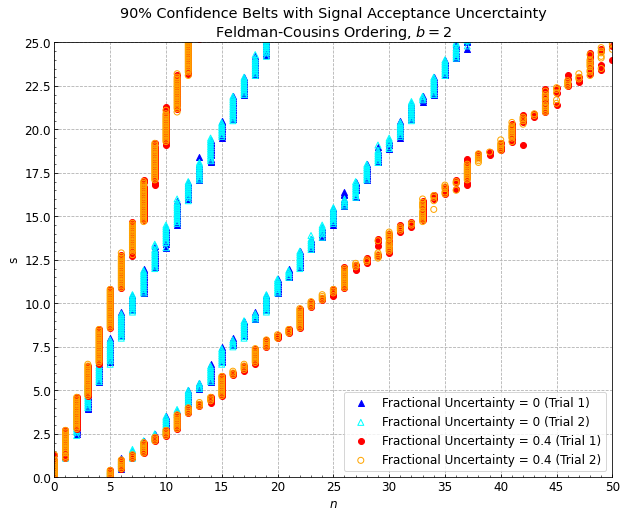

In [225]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
ax.scatter(n_limit[0,:], mus, c='blue', marker='^',
           label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.scatter(n_limit[1,:], mus, c='blue', marker='^')
ax.scatter(n_limit2[0,:], mus2, marker='^', facecolors='none', edgecolors='cyan',
           label=r'Fractional Uncertainty = 0 (Trial 2)')
ax.scatter(n_limit2[1,:], mus2, marker='^', facecolors='none', edgecolors='cyan')
ax.scatter(n_limit_[0,:], mus_, c='red',
           label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.scatter(n_limit_[1,:], mus_, c='red')
ax.scatter(n_limit_2[0,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange',
           label=r'Fractional Uncertainty = 0.4 (Trial 2)')
ax.scatter(n_limit_2[1,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,50])
ax.set_ylim([0,25])
ax.set_xticks(np.arange(0, 55, 5))
ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel('s');
ax.set_title('90% Confidence Belts with Signal Acceptance Uncerctainty\n'+r'Feldman-Cousins Ordering, $b = 2$')
ax.legend()
fig.savefig('fig2_recreate.png', transparent=False)
fig.savefig('fig2_recreate.pdf', transparent=False)

# Make Plot for Mu2e SU2020

## SU2020 Background Numbers

In [226]:
NPOT = 3.77e19
scaleLuminosity_ = 1.
dio_bkg = 0.0096  #see docdb-36476 Table 9                                                                                                          
dio_frac_unc = 0.834  #using systematic upper estimate with statistical error                                                                       
rpc_bkg = 7.06e-4  #see docdb-36503 section 11.2                                                                                                    
rpc_frac_unc = 0.16  #using systematic upper estimate with statistical error                                                                        
extinction = 1.  #in units of 10^-10, FIXME: Get expected value                                                                                     
rpc_oot_bkg = 13.9e-4*extinction  #see docdb-36503 section 11.3                                                                                     
rpc_oot_frac_unc = 0.12  #using systematic upper estimate with statistical error                                                                    
pbar_bkg = 0.069 * NPOT/3.6e20  #see docdb-36494 eq 60                                                                                           
pbar_frac_unc = 1.  #100% uncertainty quoted - careful with Gaussian mode!                                                                          
cr_lo_bkg = 0.03  #see docdb-38052 slide 20                                                                                                         
cr_lo_frac_unc = 0.20                                                                                                                                
cr_hi_bkg = 0.02  #see docdb-38052 slide 20                                                                                                         
cr_hi_frac_unc = 0.50                                                                                                                                
lumi_frac_unc = 0.1                                                                                                                                  
signal_acceptance = 0.1114  #see docdb-36491 Table 5                                                                                                
sig_frac_unc = 0.0715  #taken as the average of the momentum scale, but should be two-sided and correlated with DIO                                 
#ses = 1./(scaleLuminosity_*3.77e19*1.59e-3*0.609)  #for signal strength -> R_mue
ses = (NPOT*1.88e-3* .609 * signal_acceptance)**(-1)
# ses = (N_POT * P_mu_stop * f_capture * signal_acceptance) # see docdb-36491 Table 5 for numbers

In [227]:
3.8e20 

3.8e+20

In [228]:
3.6e20 * signal_acceptance

4.0104e+19

In [229]:
3.6e20 * 0.0903

3.2508e+19

In [230]:
ses

2.0796886280602864e-16

In [231]:
ses

2.0796886280602864e-16

### Backgrounds

In [232]:
bgs = np.array([dio_bkg, rpc_bkg, rpc_oot_bkg, pbar_bkg, cr_lo_bkg, cr_hi_bkg])
frac_uncs = np.array([dio_frac_unc, rpc_frac_unc, rpc_oot_frac_unc, pbar_frac_unc, cr_lo_frac_unc, cr_hi_frac_unc])

In [233]:
bgs, frac_uncs

(array([0.0096    , 0.000706  , 0.00139   , 0.00722583, 0.03      ,
        0.02      ]),
 array([0.834, 0.16 , 0.12 , 1.   , 0.2  , 0.5  ]))

In [234]:
total_bg = np.sum(bgs)
total_bg

0.06892183333333333

In [235]:
uncs = frac_uncs * bgs
uncs

array([0.0080064 , 0.00011296, 0.0001668 , 0.00722583, 0.006     ,
       0.01      ])

In [236]:
total_bg_unc = np.linalg.norm(uncs)
total_bg_unc

0.01588570711434373

In [237]:
total_bg_frac_unc = total_bg_unc / total_bg
total_bg_frac_unc

0.23048874857280927

In [238]:
np.sum(np.square(uncs))**(1/2)

0.01588570711434373

### Signal Efficiency

In [239]:
signal_acceptance

0.1114

In [240]:
sig_frac_unc

0.0715

## Run with the different input files

In [242]:
N_exp = int(1e5)

In [243]:
# no signal uncertainty
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = main(ini_file='data/su2020_no_sys.ini',
                                                                     N_exp=N_exp)
mus2, Philow2, Phihigh2, n_limit2, matrix2, fluxarray2, nent2, steps2 = main(ini_file='data/su2020_no_sys.ini',
                                                                             N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.100
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          50.000
Number of steps: 500
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [0.06892183]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/0.06892183333333333
-
-

.

Neyman Upper Limit: 2.2000000000000006
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.30000
 FC lower limit: 0.00000


Calculation complete!
Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000

In [244]:
# signal uncertainty
mus_, Philow_, Phihigh_, n_limit_, matrix_, fluxarray_, nent_, steps_ = main(ini_file='data/su2020_sys.ini',
                                                                     N_exp=N_exp)
mus_2, Philow_2, Phihigh_2, n_limit_2, matrix_2, fluxarray_2, nent_2, steps_2 = main(ini_file='data/su2020_sys.ini',
                                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.100
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.071
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.230
Parametrization: 3
max flux:          50.000
Number of steps: 500
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [0.06892183]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/0.06892183333333333
-
-

.

Neyman Upper Limit: 2.2000000000000006
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.40000
 FC lower limit: 0.00000


Calculation complete!
Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000

In [245]:
#mus, n_limit

In [246]:
mus.shape, n_limit.shape

((500,), (2, 500))

In [257]:
b = 0.06892183

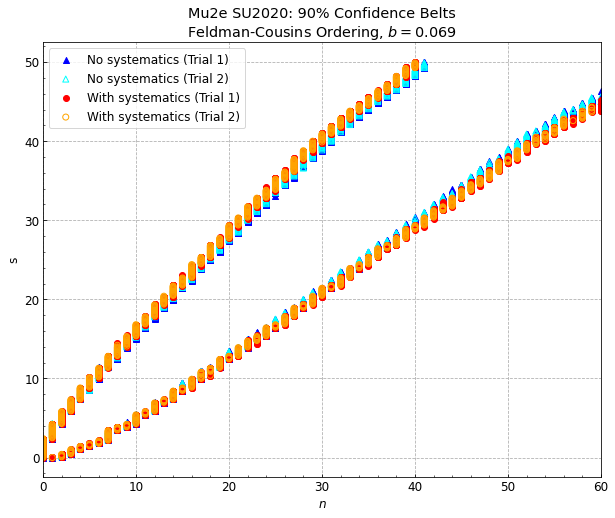

In [260]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
ax.scatter(n_limit[0,:], mus, c='blue', marker='^',
           label='No systematics (Trial 1)')
           #label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.scatter(n_limit[1,:], mus, c='blue', marker='^')
ax.scatter(n_limit2[0,:], mus2, marker='^', facecolors='none', edgecolors='cyan',
           label='No systematics (Trial 2)')
#            label=r'Fractional Uncertainty = 0 (Trial 2)')
ax.scatter(n_limit2[1,:], mus2, marker='^', facecolors='none', edgecolors='cyan')
ax.scatter(n_limit_[0,:], mus_, c='red',
           label='With systematics (Trial 1)')
#            label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.scatter(n_limit_[1,:], mus_, c='red')
ax.scatter(n_limit_2[0,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange',
           label='With systematics (Trial 2)')
#            label=r'Fractional Uncertainty = 0.4 (Trial 2)')
ax.scatter(n_limit_2[1,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,60])
#ax.set_ylim([0,12])
#ax.set_xticks(np.arange(0, 55, 5))
# ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel('s');
ax.set_title('Mu2e SU2020: 90% Confidence Belts\n'+rf'Feldman-Cousins Ordering, $b = {total_bg:0.3f}$')
ax.legend()
fig.savefig('su2020_CI.png', transparent=False)
fig.savefig('su2020_CI.pdf', transparent=False)

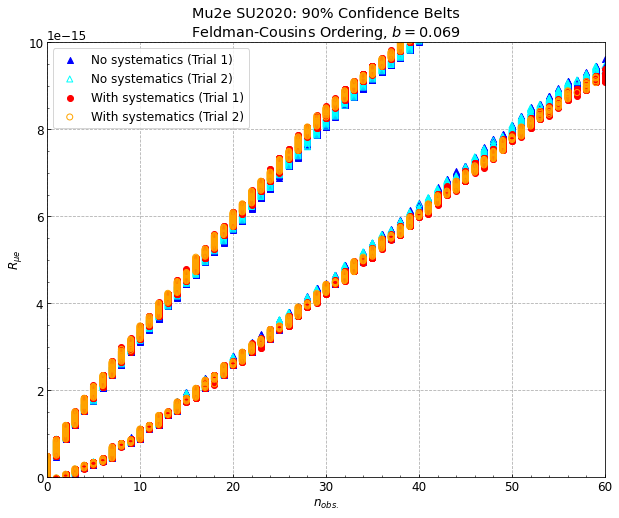

In [259]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
ax.scatter(n_limit[0,:], ses*mus, c='blue', marker='^',
           label='No systematics (Trial 1)')
           #label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.scatter(n_limit[1,:],  ses*mus, c='blue', marker='^')
ax.scatter(n_limit2[0,:],  ses*mus2, marker='^', facecolors='none', edgecolors='cyan',
           label='No systematics (Trial 2)')
#            label=r'Fractional Uncertainty = 0 (Trial 2)')
ax.scatter(n_limit2[1,:],  ses*mus2, marker='^', facecolors='none', edgecolors='cyan')
ax.scatter(n_limit_[0,:],  ses*mus_, c='red',
           label='With systematics (Trial 1)')
#            label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.scatter(n_limit_[1,:],  ses*mus_, c='red')
ax.scatter(n_limit_2[0,:],  ses*mus_2, marker='o', facecolors='none', edgecolors=f'orange',
           label='With systematics (Trial 2)')
#            label=r'Fractional Uncertainty = 0.4 (Trial 2)')
ax.scatter(n_limit_2[1,:],  ses*mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,60])
ax.set_ylim([0,1e-14])
#ax.set_xticks(np.arange(0, 55, 5))
# ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n_{obs.}$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel(r'$R_{\mu e}$');
ax.set_title('Mu2e SU2020: 90% Confidence Belts\n'+rf'Feldman-Cousins Ordering, $b = {total_bg:0.3f}$')
ax.legend()
fig.savefig('su2020_CI_ses.png', transparent=False)
fig.savefig('su2020_CI_ses.pdf', transparent=False)

In [211]:
ses

2.0796886280602864e-16

# Calculate Limits for some interesting cases of $n_{obs}$
**CAUTION: These take a long time to run.**
- Width = 0.01

In [242]:
N_exp = int(1e5)

In [254]:
# no signal uncertainty
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = main(ini_file='data/su2020_no_sys_n_calcs.ini',
                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.010
Feldman Cousins    1
fluxfactor:        1.000
Read from file: su2020.in
Write to file: su2020_no_sys.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          50.000
Number of steps: 5000
CAUTION: not bigger than 1000!
-
-
Mode: Read input from file
-
expected background (x): [0.06892183 0.06892183 0.06892183 0.06892183 0.06892183 0.06892183
 0.06892183]
number of observed (y): [ 0.  1.  2.  4.  8. 16. 32.]
-
Performing Construction for n0/bg: 0.0/0.06892183333333333
-
-

.

Neyman Upper Limit: 2.209999999999997
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.37000
 FC lower limit: 0.00000


-
Performing Constru

In [255]:
# signal uncertainty
mus_, Philow_, Phihigh_, n_limit_, matrix_, fluxarray_, nent_, steps_ = main(ini_file='data/su2020_sys_n_calcs.ini',
                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.010
Feldman Cousins    1
fluxfactor:        1.000
Read from file: su2020.in
Write to file: su2020_sys.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.071
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.230
Parametrization: 3
max flux:          50.000
Number of steps: 5000
CAUTION: not bigger than 1000!
-
-
Mode: Read input from file
-
expected background (x): [0.06892183 0.06892183 0.06892183 0.06892183 0.06892183 0.06892183
 0.06892183]
number of observed (y): [ 0.  1.  2.  4.  8. 16. 32.]
-
Performing Construction for n0/bg: 0.0/0.06892183333333333
-
-

.

Neyman Upper Limit: 2.249999999999996
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.40000
 FC lower limit: 0.00000


-
Performing Constructi

In [256]:
ses

2.0796886280602864e-16

# Compare with M. MacKenzie
- Code in C++/ROOT

In [212]:
N_exp = int(1e5)

In [216]:
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = main(ini_file='data/su2020_no_sys_mmackenz.ini',
                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.025
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          20.000
Number of steps: 800
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [0.0689218]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/0.0689218
-
-

.
.
.

Neyman Upper Limit: 2.199999999999996
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.37500
 FC lower limit: 0.00000


Calculation complete!


In [214]:
2.2*ses

4.575314981732631e-16

In [217]:
(2.375+2.400)/2

2.3875

# Profiling Code

In [38]:
%prun main()

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.010
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     3.000
Measured events    7
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.109
Parametrization: 3
max flux:          5.000
Number of steps: 500
CAUTION: not bigger than 1000!
-
-
Mode: Read input from file
-
expected background (x): [0.041]
number of observed (y): [0.]
-
Performing Construction for n0/bg: 0.0/0.041
-
-

.
.
.
.
.
.
.
.
.
.

Neyman Upper Limit: 2.259999999999996
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.41000
 FC lower limit: 0.00000


Calculation complete!
 

In [ ]:
#ses = 5.56e-17
#ses * 2.2, ses*

- Currently runs quite a bit slower than FORTRAN
- Vectorize and should run quicker.
- Could also try using Gaussian approx for mu>20 (Poisson)

# SCRATCH

## Log Normal vs. Gaussian

In [79]:
N = 100000
mu = 1
std = 0.4
var = std**2

In [80]:
# generate gaussian and look at sample mean / std
xs = np.random.normal(loc=mu, scale=std, size=N)

In [81]:
xs.mean(), xs.std()

(1.001047438157665, 0.39941000718227043)

In [82]:
std_ln = std
mu_ln = np.log(mu) - std**2 / 2

In [84]:
std_ln, mu_ln

(0.4, -0.08000000000000002)

In [87]:
# generate log-normal
ys = np.random.lognormal(mean=mu_ln, sigma=std_ln, size=N)

In [88]:
ys.mean(), ys.std()

(0.9982725656238518, 0.41613017191659896)

- These look pretty close! Let's try the wiki method, which should get both spot on

In [93]:
mu_ln = np.log(mu**2 / (mu**2 + std**2)**(1/2))
std_ln = (np.log(1+std**2/mu**2))**(1/2)

In [94]:
mu_ln, std_ln

(-0.07421000255913678, 0.38525317015992666)

In [95]:
# generate log-normal
ys = np.random.lognormal(mean=mu_ln, sigma=std_ln, size=N)

In [96]:
ys.mean(), ys.std()

(0.9986280186915583, 0.3984484719297211)

- Looks about the same as Conrad result.

**Prescription**
- $\mu, \sigma$ for a nuisance parameter given (expected background, signal efficiency, background efficiency)
- If log-normal parameterization selected (3), then:
    - $\mu_{LN} = \ln{\mu} - \sigma^2 / 2$
    - $\sigma_{LN} = \sigma$
    - These are the parameters to use with the log-normal generator